In [23]:
import sys

import matplotlib.pyplot as plt
import json
import os.path
import itertools

import dysts
from dysts.flows import *
from dysts.base import *
from dysts.utils import *
from dysts.analysis import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Make datasets without noise

In [ ]:
DATA_BASEPATH = "../dysts/data/"
np.random.seed(0)

num_periods = {
    "train": 12,
    "test": 12
}
for (ts_type, subset, pts_per_period) in itertools.product(
                                                      ["univariate", "multivariate"], 
                                                      ["train", "test"], 
                                                      [15, 100]
                                                    ):
    output_path = os.path.join(DATA_BASEPATH, f"{subset}_{ts_type}__pts_per_period_{pts_per_period}__periods_{num_periods[subset]}.json")
    dataset = dict()

    for i, name in enumerate(get_attractor_list()):
        print(name)
        dataset[name] = dict()
        model = getattr(dysts.flows, name)()
        # make initial conditions for train, val, test
        [train_ic, val_ic, test_ic] = sample_initial_conditions(model, 3)

        if subset == "train":
            model.ic = train_ic
        elif subset == "val":
            model.ic = val_ic
        elif subset == "test":
            model.ic = test_ic
        else:
            pass
        tpts, sol = model.make_trajectory(num_periods[subset] * pts_per_period, pts_per_period=pts_per_period, 
                                       resample=True, return_times=True)


        if ts_type == "univariate":
            values = sol[:, 0].tolist()
        elif ts_type == "multivariate":
            values = sol.tolist()
        else:
            warnings.warn("Specified time series type not \"univariate\" or \"multivariate\", falling back to univariate")
            values = sol[:, 0]

        dataset[name]["time"] = tpts.tolist()
        dataset[name]["dt"] = np.median(np.diff(tpts))

        dataset[name]["values"] = values
        with open(output_path, 'w') as f:
            json.dump(dataset, f, indent=4)

# Make dataset with noise

In [250]:
# sol = model.make_trajectory(1000, pts_per_period=pts_per_period, resample=True)

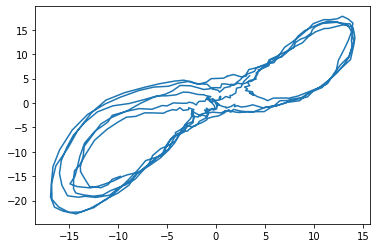

In [78]:

sol = Lorenz().make_trajectory(500, noise=0.2, resample=True)
plt.plot(sol[:, 0], sol[:, 1])

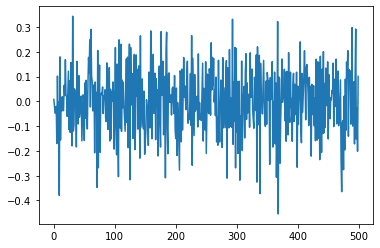

In [273]:
plt.plot(sol[:, 0]- sol_detrend)

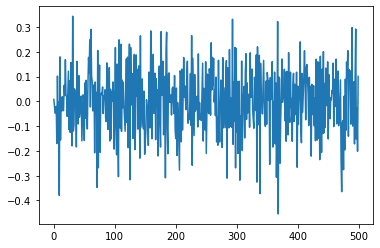

In [277]:
plt.plot(sol[:, 0]- sol_detrend)

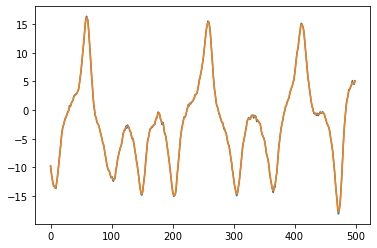

In [276]:
import scipy.signal
# sol_detrend = scipy.signal.detrend(sol[:, 0])

plt.plot(sol[:, 0])
plt.plot(sol_detrend)

In [75]:
# import errno
# import os
# import signal
# import functools

# class TimeoutError(Exception):
#     pass

# def timeout(seconds=10, error_message=os.strerror(errno.ETIME)):
#     def decorator(func):
#         def _handle_timeout(signum, frame):
#             raise TimeoutError(error_message)

#         @functools.wraps(func)
#         def wrapper(*args, **kwargs):
#             signal.signal(signal.SIGALRM, _handle_timeout)
#             signal.alarm(seconds)
#             try:
#                 result = func(*args, **kwargs)
#             finally:
#                 signal.alarm(0)
#             return result

#         return wrapper

#     return decorator



import signal

class timeout:
    def __init__(self, seconds=1, error_message='Timeout'):
        self.seconds = seconds
        self.error_message = error_message
    def handle_timeout(self, signum, frame):
        raise TimeoutError(self.error_message)
    def __enter__(self):
        signal.signal(signal.SIGALRM, self.handle_timeout)
        signal.alarm(self.seconds)
    def __exit__(self, type, value, traceback):
        signal.alarm(0)

In [80]:
qq = sample_initial_conditions(model, 3)
qq2 = sample_initial_conditions(model, 1)

/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1361.6323363431152
  warnings.warn(


In [82]:
qq2

array([[-1.21678663e+00,  6.99678421e-02,  7.59514260e+02]])

In [83]:
import time

In [85]:
complete_flag = False
while not complete_flag:
    try:
        with timeout(seconds=3):
            tpts, sol = model.make_trajectory(num_periods[subset] * pts_per_period, pts_per_period=pts_per_period, 
                           resample=True, return_times=True)
            complete_flag = True
    except:
        np.random.random() # just to make sure seed iterates
        [new_ic] = sample_initial_conditions(model, 1)
        model.ic = new_ic
        print("Retrying...")

TimeoutError: Timeout

In [36]:
import scipy.signal
DATA_BASEPATH = "../dysts/data/"
np.random.seed(0)


import torch
from torchsde import sdeint
from dysts.flows import Lorenz
class SDE(torch.nn.Module):

    def __init__(self, rhs, sigma):
        super().__init__()
        self.noise_type="diagonal"
        self.sde_type = "ito"
        self.sigma = sigma
        self.rhs = rhs

    def f(self, t, y):
        return self.rhs(y, t)

    def g(self, t, y):
        return self.sigma * y


# ts_type = "multivariate"
# subset = "train"
# pts_per_period = 15 # granularity 15 or 100
# pts_per_period = 100 # granularity 15 or 100


# num_periods = {
#     "large": 100,
#     "train": 10,
#     "val": 2,
#     "test": 2
# }

## iterate over uni/multi, train partition, and granularity
# for (ts_type, subset, pts_per_period) in itertools.product(
#                                                       ["univariate", "multivariate"], 
#                                                       ["train", "val", "test"], 
#                                                       [15, 100]
#                                                     ):

# for (ts_type, subset, pts_per_period) in [("univariate", "large", 100)]:

NOISE_FLAG = True
num_periods = {
    "train": 12,
    "test": 12
}

ts_combos = list(itertools.product(
    ["multivariate", "univariate"], 
    ["train", "test"], 
    [100, 15]
))

for (ts_type, subset, pts_per_period) in ts_combos[1:]:
    
    print(ts_type, subset, pts_per_period)
    
    if NOISE_FLAG:
        output_path = os.path.join(DATA_BASEPATH, f"{subset}_{ts_type}__pts_per_period_{pts_per_period}__periods_{num_periods[subset]}_noise.json")
    else:
        output_path = os.path.join(DATA_BASEPATH, f"{subset}_{ts_type}__pts_per_period_{pts_per_period}__periods_{num_periods[subset]}.json")
    
    dataset = dict()

    for i, name in enumerate(get_attractor_list()):
        
#         if name != "LiuChen":
#             continue
        
        print(name)
        dataset[name] = dict()
        model = getattr(dysts.flows, name)()
        # make initial conditions for train, val, test
        [train_ic, val_ic, test_ic] = sample_initial_conditions(model, 3)
        
        [train_ic, val_ic, test_ic] = sample_initial_conditions(model, 3)

        if subset == "train":
            model.ic = train_ic
        elif subset == "val":
            model.ic = val_ic
        elif subset == "test":
            model.ic = test_ic
        else:
            pass
        
        
        tpts, sol = model.make_trajectory(num_periods["train"] * 100, pts_per_period=100, 
                               resample=True, return_times=True)
        
        
        
#         sol = model.make_trajectory(500, pts_per_period=pts_per_period, resample=True)
        #noise_scale = 0.02 * np.median(np.abs(sol))
        #noise_scale = 0.01 * np.max(np.median(np.abs(sol), axis=1))
        #noise_scale = 0.01 * np.min(np.median(np.abs(sol), axis=1))
#         noise_scale = 0.02 * np.max(np.std(sol, axis=0))
#         noise_scale = 0.01
        #noise_scale = 0.01 * np.min(np.std(sol, axis=0))
        #noise_scale = 0.02 * np.median(np.std(sol, axis=0)) / (10 * np.sqrt(model.dt))
#         noise_scale =  0.01 * np.max(np.std(sol, axis=0)) / (10 * np.sqrt(model.dt))
#         print(model.dt, model.period)
        
        
#         ref_traj = model.make_trajectory(5000, pts_per_period=pts_per_period, resample=False)
#         noise_traj = model.make_trajectory(5000, noise=0.5, pts_per_period=pts_per_period, resample=False)
#         noise_scale = np.max(np.sqrt(np.abs(np.var(noise_traj, axis=0) - np.var(ref_traj, axis=0))))
#         noise_scale = 0.1 * 1.5 / noise_scale
        
#         ref_traj = model.make_trajectory(2, pts_per_period=pts_per_period, resample=True)
#         noise_traj = model.make_trajectory(2, noise=0.5, pts_per_period=pts_per_period, resample=True)
#         noise_scale = np.median(np.abs((ref_traj - noise_traj)[-1]))
#         noise_scale = 0.35 * 0.025 / noise_scale
# #         noise_scale = 0.2 * 2.219312524586793 *  noise_scale
        
    
    
        solver_settings = {
            "pts_per_period" : pts_per_period,
            "resample" : True,
            "method" : "Radau",
            "return_times" : True
        }
        
    
#         model.dt /= 10
        
#         noise_start = 0.05
#         _, noise_traj = model.make_trajectory(5000, noise=noise_start, **solver_settings)
#         if np.any(np.isnan(noise_traj)):
#             while np.any(np.isnan(noise_traj)):
#                 np.random.random()
#                 noise_start *= .5
#                 _, noise_traj = model.make_trajectory(5000, noise=noise_start, **solver_settings)
        
#         all_noise_vals = list()
#         for row in noise_traj.T:
#             try:
#                 row_detrend = scipy.signal.savgol_filter(row, 7, 1)
#                 all_noise_vals.append(np.std(row - row_detrend))
#             except:
#                 pass
#         noise_scale = np.min(all_noise_vals)
#         noise_scale = 0.005 * 0.025 / noise_scale * (.0007/model.dt)**0.5
        
#         noise_scale = 0.1 * np.min(np.std(noise_traj, axis=0)) #* (.0007/model.dt)**-2
#         noise_scale = 0.05 * np.median(np.std(noise_traj, axis=0)) * np.sqrt(3/model.embedding_dimension)
        
        noise_traj = sol
        
        
        noise_scale = 0.025 * np.std(noise_traj, axis=0)# * np.sqrt(3/model.embedding_dimension)
        
        if model.nonautonomous:
            noise_scale[2] = 0
        #noise_scale[model.unbounded_indices] = 0
            
#             noise_scale[2] *= 0.1
#             noise_scale[:2] = 0
#             noise_scale[3:] = 0
# #             print(noise_scale)
            
#             noise_scale[1:] = 0
        
#         if name in ["ForcedVanDerPol", "JerkCircuit", "LiuChen", "BeerRNN"]:
#             #noise_scale = 0
#             noise_scale = np.array([0.001, 0, 0])
#             model = getattr(dysts.flows, name)()

        if model.delay:
            noise_scale = np.median(noise_scale)
    
        tpts, sol = model.make_trajectory(num_periods[subset] * pts_per_period, 
                                          noise=noise_scale, 
                                          **solver_settings
                                         )
        
        if np.any(np.isnan(sol)):
            # Deal with bad integration
            while np.any(np.isnan(sol)):
                model = getattr(dysts.flows, name)()
                np.random.random()
                noise_scale *= 0.5
                
                if model.delay:
                    if noise_scale < 1e-7:
                        noise_scale = 0.0
                else:
                    noise_scale[noise_scale < 1e-7] = 0.0
                #model.dt *= 0.5
                print(f"Noise scale reduced to {noise_scale} due to errors in integration")
                np.random.random() # just to make sure seed iterates
                [new_ic] = sample_initial_conditions(model, 1)
                model.ic = new_ic
                tpts, sol = model.make_trajectory(num_periods[subset] * pts_per_period, 
                                                  noise=noise_scale, 
                                                 **solver_settings
                                                 )
                
#         if model.delay:
#             continue
        
#         eq = model
        
#         if hasattr(eq, "_rhs"):
#             param_list = [
#                 getattr(eq, param_name) for param_name in eq.get_param_names()
#             ]
#             rhs = lambda y, t : torch.tensor([eq._rhs.py_func(*y.T, t, *param_list)])
#         else:
#             rhs = lambda y, t : torch.tensor([eq.rhs(y.T, t)])

#         sde = SDE(rhs, torch.tensor(0.03 * np.std(eq.make_trajectory(1000), axis=0)) )
#         sol = sdeint(sde, torch.tensor([eq.ic]), torch.tensor(tpts), dt=eq.dt)
#         sol = np.squeeze(np.array(sol))

        if ts_type == "univariate":
            values = sol[:, 0].tolist()
        elif ts_type == "multivariate":
            values = sol.tolist()
        else:
            warnings.warn("Specified time series type not \"univariate\" or \"multivariate\", falling back to univariate")
            values = sol[:, 0]

        dataset[name]["time"] = tpts.tolist()
        dataset[name]["dt"] = np.median(np.diff(tpts))

        dataset[name]["values"] = values
        with open(output_path, 'w') as f:
            json.dump(dataset, f, indent=4)  
          
    
    
    
#     break
    


multivariate train 15
Aizawa
AnishchenkoAstakhov
Noise scale reduced to [0.01819919 0.0204463  0.01122864] due to errors in integration
Noise scale reduced to [0.0090996  0.01022315 0.00561432] due to errors in integration
Noise scale reduced to [0.0045498  0.00511157 0.00280716] due to errors in integration
Noise scale reduced to [0.0022749  0.00255579 0.00140358] due to errors in integration
Noise scale reduced to [0.00113745 0.00127789 0.00070179] due to errors in integration
Noise scale reduced to [0.00056872 0.00063895 0.00035089] due to errors in integration
Noise scale reduced to [0.00028436 0.00031947 0.00017545] due to errors in integration
Arneodo
ArnoldBeltramiChildress
ArnoldWeb
BeerRNN
Noise scale reduced to [0.02723896 0.00537459 0.00744944] due to errors in integration
Noise scale reduced to [0.01361948 0.00268729 0.00372472] due to errors in integration
Noise scale reduced to [0.00680974 0.00134365 0.00186236] due to errors in integration
Noise scale reduced to [0.00340

/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/flows.py:1102: RuntimeWarning: invalid value encountered in double_scalars
  alpham = 0.1 * (25 + v) / (1 - np.exp(-0.1 * v - 2.5))
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/flows.py:1110: RuntimeWarning: invalid value encountered in double_scalars
  alphan = 0.01 * (20 + v) / (1 - np.exp(-0.1 * v - 2))


Noise scale reduced to [4.06692884e-07 0.00000000e+00 0.00000000e+00] due to errors in integration
Noise scale reduced to [2.03346442e-07 0.00000000e+00 0.00000000e+00] due to errors in integration
Noise scale reduced to [1.01673221e-07 0.00000000e+00 0.00000000e+00] due to errors in integration
Noise scale reduced to [0. 0. 0.] due to errors in integration
Finance
Noise scale reduced to [0.01142276 0.00873772 0.00862946] due to errors in integration
Noise scale reduced to [0.00571138 0.00436886 0.00431473] due to errors in integration
Noise scale reduced to [0.00285569 0.00218443 0.00215736] due to errors in integration
Noise scale reduced to [0.00142784 0.00109221 0.00107868] due to errors in integration
Noise scale reduced to [0.00071392 0.00054611 0.00053934] due to errors in integration
Noise scale reduced to [0.00035696 0.00027305 0.00026967] due to errors in integration
Noise scale reduced to [0.00017848 0.00013653 0.00013484] due to errors in integration
Noise scale reduced to 

/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/flows.py:460: RuntimeWarning: overflow encountered in double_scalars
  alphadot = mu * (kappa + gamma) - alpha * beta ** 2 - alpha
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/flows.py:461: RuntimeWarning: overflow encountered in double_scalars
  betadot = (alpha * beta ** 2 + alpha - beta) / sigma


Noise scale reduced to [0.00071135 0.00631408 0.00069981] due to errors in integration
Noise scale reduced to [0.00035568 0.00315704 0.0003499 ] due to errors in integration
Noise scale reduced to [0.00017784 0.00157852 0.00017495] due to errors in integration
Noise scale reduced to [8.89191296e-05 7.89259393e-04 8.74757844e-05] due to errors in integration
ItikBanksTumor


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1333.3333333333333
  warnings.warn(


Noise scale reduced to [0.00253429 0.00389488 0.00217879] due to errors in integration
Noise scale reduced to [0.00126714 0.00194744 0.0010894 ] due to errors in integration
Noise scale reduced to [0.00063357 0.00097372 0.0005447 ] due to errors in integration
Noise scale reduced to [0.00031679 0.00048686 0.00027235] due to errors in integration
Noise scale reduced to [0.00015839 0.00024343 0.00013617] due to errors in integration
Noise scale reduced to [7.91964470e-05 1.21715082e-04 6.80873155e-05] due to errors in integration
Noise scale reduced to [3.95982235e-05 6.08575412e-05 3.40436577e-05] due to errors in integration
Noise scale reduced to [1.97991117e-05 3.04287706e-05 1.70218289e-05] due to errors in integration
Noise scale reduced to [9.89955587e-06 1.52143853e-05 8.51091444e-06] due to errors in integration
Noise scale reduced to [4.94977794e-06 7.60719265e-06 4.25545722e-06] due to errors in integration
Noise scale reduced to [2.47488897e-06 3.80359632e-06 2.12772861e-06] 

/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1731.6065865598578
  warnings.warn(


Noise scale reduced to [0.00885501 0.00596343 0.00600315] due to errors in integration
Noise scale reduced to [0.00442751 0.00298172 0.00300157] due to errors in integration
Noise scale reduced to [0.00221375 0.00149086 0.00150079] due to errors in integration
Noise scale reduced to [0.00110688 0.00074543 0.00075039] due to errors in integration
Noise scale reduced to [0.00055344 0.00037271 0.0003752 ] due to errors in integration
Noise scale reduced to [0.00027672 0.00018636 0.0001876 ] due to errors in integration
Noise scale reduced to [1.38359566e-04 9.31786545e-05 9.37992047e-05] due to errors in integration
Noise scale reduced to [6.91797828e-05 4.65893272e-05 4.68996024e-05] due to errors in integration
Noise scale reduced to [3.45898914e-05 2.32946636e-05 2.34498012e-05] due to errors in integration
Noise scale reduced to [1.72949457e-05 1.16473318e-05 1.17249006e-05] due to errors in integration
Noise scale reduced to [8.64747285e-06 5.82366590e-06 5.86245030e-06] due to error

/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1801.8431108114187
  warnings.warn(
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 3603.686221622837
  warnings.warn(


Noise scale reduced to [0.10598239 0.01935708 0.02998393] due to errors in integration
Noise scale reduced to [0.05299119 0.00967854 0.01499196] due to errors in integration
Noise scale reduced to [0.0264956  0.00483927 0.00749598] due to errors in integration
Noise scale reduced to [0.0132478  0.00241964 0.00374799] due to errors in integration
Noise scale reduced to [0.0066239  0.00120982 0.001874  ] due to errors in integration
Noise scale reduced to [0.00331195 0.00060491 0.000937  ] due to errors in integration
Noise scale reduced to [0.00165597 0.00030245 0.0004685 ] due to errors in integration
Noise scale reduced to [0.00082799 0.00015123 0.00023425] due to errors in integration
Noise scale reduced to [4.13993705e-04 7.56136013e-05 1.17124724e-04] due to errors in integration
Noise scale reduced to [2.06996852e-04 3.78068006e-05 5.85623619e-05] due to errors in integration
Noise scale reduced to [1.03498426e-04 1.89034003e-05 2.92811809e-05] due to errors in integration
Noise s

/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1149.4214876033059
  warnings.warn(


Noise scale reduced to [0.01038555 0.01679295 0.02156944] due to errors in integration
Noise scale reduced to [0.00519278 0.00839648 0.01078472] due to errors in integration
Noise scale reduced to [0.00259639 0.00419824 0.00539236] due to errors in integration
Noise scale reduced to [0.00129819 0.00209912 0.00269618] due to errors in integration
Noise scale reduced to [0.0006491  0.00104956 0.00134809] due to errors in integration
Noise scale reduced to [0.00032455 0.00052478 0.00067405] due to errors in integration
Noise scale reduced to [0.00016227 0.00026239 0.00033702] due to errors in integration
Noise scale reduced to [8.11371134e-05 1.31194949e-04 1.68511277e-04] due to errors in integration
Noise scale reduced to [4.05685567e-05 6.55974745e-05 8.42556383e-05] due to errors in integration
Noise scale reduced to [2.02842784e-05 3.27987372e-05 4.21278191e-05] due to errors in integration
Noise scale reduced to [1.01421392e-05 1.63993686e-05 2.10639096e-05] due to errors in integra

/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1025.6302521008404
  warnings.warn(
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/flows.py:52: RuntimeWarning: overflow encountered in double_scalars
  Xdot[0] = (X[1] - X[-2]) * X[-1] - X[0] + self.f
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/flows.py:53: RuntimeWarning: overflow encountered in double_scalars
  Xdot[1] = (X[2] - X[-1]) * X[0] - X[1] + self.f
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/flows.py:54: RuntimeWarning: overflow encountered in double_scalars
  Xdot[-1] = (X[0] - X[-3]) * X[-2] - X[-1] + self.f
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/flows.py:55: RuntimeWarning: overflow encountered in multiply
  Xdot[2:-1] = (X[3:] - X[:-3]) * X[1:-2] - X[2:-1] + self.f
/Use

Noise scale reduced to [0.08933058 0.08469405 0.08491917 0.08596425] due to errors in integration
Noise scale reduced to [0.04466529 0.04234702 0.04245959 0.04298212] due to errors in integration
Noise scale reduced to [0.02233265 0.02117351 0.02122979 0.02149106] due to errors in integration
Noise scale reduced to [0.01116632 0.01058676 0.0106149  0.01074553] due to errors in integration
Noise scale reduced to [0.00558316 0.00529338 0.00530745 0.00537277] due to errors in integration
Noise scale reduced to [0.00279158 0.00264669 0.00265372 0.00268638] due to errors in integration
Noise scale reduced to [0.00139579 0.00132334 0.00132686 0.00134319] due to errors in integration
Noise scale reduced to [0.0006979  0.00066167 0.00066343 0.0006716 ] due to errors in integration
Noise scale reduced to [0.00034895 0.00033084 0.00033172 0.0003358 ] due to errors in integration
Noise scale reduced to [0.00017447 0.00016542 0.00016586 0.0001679 ] due to errors in integration
Noise scale reduced 

/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1282.0723684210525
  warnings.warn(


Noise scale reduced to [0.09037125 0.09262673 0.06489769] due to errors in integration
Noise scale reduced to [0.04518562 0.04631336 0.03244884] due to errors in integration
Noise scale reduced to [0.02259281 0.02315668 0.01622442] due to errors in integration
Noise scale reduced to [0.01129641 0.01157834 0.00811221] due to errors in integration
Noise scale reduced to [0.0056482  0.00578917 0.00405611] due to errors in integration
Noise scale reduced to [0.0028241  0.00289459 0.00202805] due to errors in integration
Noise scale reduced to [0.00141205 0.00144729 0.00101403] due to errors in integration
Noise scale reduced to [0.00070603 0.00072365 0.00050701] due to errors in integration
Noise scale reduced to [0.00035301 0.00036182 0.00025351] due to errors in integration
Noise scale reduced to [0.00017651 0.00018091 0.00012675] due to errors in integration
Noise scale reduced to [8.82531695e-05 9.04557904e-05 6.33766488e-05] due to errors in integration
Noise scale reduced to [4.41265

/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:415: RuntimeWarning: invalid value encountered in double_scalars
  x_next


Noise scale reduced to 0.02313047150296879 due to errors in integration
Noise scale reduced to 0.011565235751484396 due to errors in integration
Qi
Noise scale reduced to [0.02409389 0.01891536 0.00939395 0.01477985] due to errors in integration
Noise scale reduced to [0.01204695 0.00945768 0.00469698 0.00738992] due to errors in integration
Noise scale reduced to [0.00602347 0.00472884 0.00234849 0.00369496] due to errors in integration
Noise scale reduced to [0.00301174 0.00236442 0.00117424 0.00184748] due to errors in integration
Noise scale reduced to [0.00150587 0.00118221 0.00058712 0.00092374] due to errors in integration
Noise scale reduced to [0.00075293 0.0005911  0.00029356 0.00046187] due to errors in integration
Noise scale reduced to [0.00037647 0.00029555 0.00014678 0.00023094] due to errors in integration
QiChen
Noise scale reduced to [0.32153611 0.12301703 0.12147997] due to errors in integration
Noise scale reduced to [0.16076805 0.06150851 0.06073999] due to errors 

/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1449.326303456356
  warnings.warn(


Noise scale reduced to [0.00359255 0.00517946 0.01843328] due to errors in integration
Noise scale reduced to [0.00179628 0.00258973 0.00921664] due to errors in integration
StickSlipOscillator


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1075.2666666666667
  warnings.warn(


SwingingAtwood
Thomas


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1149.4332639370807
  warnings.warn(


ThomasLabyrinth


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1149.4252873563216
  warnings.warn(


Torus


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1111.1111111111113
  warnings.warn(


Tsucs2
Noise scale reduced to [0.24364737 0.23534318 0.27756273] due to errors in integration
Noise scale reduced to [0.12182368 0.11767159 0.13878136] due to errors in integration
Noise scale reduced to [0.06091184 0.05883579 0.06939068] due to errors in integration
Noise scale reduced to [0.03045592 0.0294179  0.03469534] due to errors in integration
Noise scale reduced to [0.01522796 0.01470895 0.01734767] due to errors in integration
Noise scale reduced to [0.00761398 0.00735447 0.00867384] due to errors in integration
Noise scale reduced to [0.00380699 0.00367724 0.00433692] due to errors in integration
Noise scale reduced to [0.0019035  0.00183862 0.00216846] due to errors in integration
Noise scale reduced to [0.00095175 0.00091931 0.00108423] due to errors in integration
Noise scale reduced to [0.00047587 0.00045965 0.00054211] due to errors in integration
Noise scale reduced to [0.00023794 0.00022983 0.00027106] due to errors in integration
Noise scale reduced to [0.00011897 0

/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/flows.py:470: RuntimeWarning: overflow encountered in double_scalars
  ydot = -y + x * z
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/flows.py:471: RuntimeWarning: overflow encountered in double_scalars
  zdot = -z - x * y + 1
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/flows.py:470: RuntimeWarning: invalid value encountered in double_scalars
  ydot = -y + x * z


Noise scale reduced to [0.0666629  0.00295129 0.00300106] due to errors in integration


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/flows.py:471: RuntimeWarning: invalid value encountered in double_scalars
  zdot = -z - x * y + 1


Noise scale reduced to [0.03333145 0.00147565 0.00150053] due to errors in integration
Noise scale reduced to [0.01666573 0.00073782 0.00075026] due to errors in integration
Noise scale reduced to [0.00833286 0.00036891 0.00037513] due to errors in integration
Noise scale reduced to [0.00416643 0.00018446 0.00018757] due to errors in integration
Noise scale reduced to [2.08321573e-03 9.22278651e-05 9.37830478e-05] due to errors in integration
Noise scale reduced to [1.04160787e-03 4.61139326e-05 4.68915239e-05] due to errors in integration
Noise scale reduced to [5.20803933e-04 2.30569663e-05 2.34457619e-05] due to errors in integration
Noise scale reduced to [2.60401967e-04 1.15284831e-05 1.17228810e-05] due to errors in integration
Noise scale reduced to [1.30200983e-04 5.76424157e-06 5.86144048e-06] due to errors in integration
Noise scale reduced to [6.51004917e-05 2.88212079e-06 2.93072024e-06] due to errors in integration
Noise scale reduced to [3.25502458e-05 1.44106039e-06 1.46

/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1388.87171561051
  warnings.warn(


Noise scale reduced to [0.00910498 0.00529909 0.00407431] due to errors in integration
Noise scale reduced to [0.00455249 0.00264955 0.00203715] due to errors in integration
Noise scale reduced to [0.00227624 0.00132477 0.00101858] due to errors in integration
Noise scale reduced to [0.00113812 0.00066239 0.00050929] due to errors in integration
Noise scale reduced to [0.00056906 0.00033119 0.00025464] due to errors in integration
Noise scale reduced to [0.00028453 0.0001656  0.00012732] due to errors in integration
Noise scale reduced to [1.42265248e-04 8.27983439e-05 6.36610184e-05] due to errors in integration
Noise scale reduced to [7.11326242e-05 4.13991720e-05 3.18305092e-05] due to errors in integration
Noise scale reduced to [3.55663121e-05 2.06995860e-05 1.59152546e-05] due to errors in integration
Noise scale reduced to [1.77831561e-05 1.03497930e-05 7.95762730e-06] due to errors in integration
Noise scale reduced to [8.89157803e-06 5.17489649e-06 3.97881365e-06] due to error

/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1190.478133714208
  warnings.warn(


Noise scale reduced to [0.11165414 0.12548258 0.06299295] due to errors in integration
Noise scale reduced to [0.05582707 0.06274129 0.03149647] due to errors in integration
Noise scale reduced to [0.02791353 0.03137065 0.01574824] due to errors in integration
Noise scale reduced to [0.01395677 0.01568532 0.00787412] due to errors in integration
Noise scale reduced to [0.00697838 0.00784266 0.00393706] due to errors in integration
Noise scale reduced to [0.00348919 0.00392133 0.00196853] due to errors in integration
Noise scale reduced to [0.0017446  0.00196067 0.00098426] due to errors in integration
Noise scale reduced to [0.0008723  0.00098033 0.00049213] due to errors in integration
Noise scale reduced to [0.00043615 0.00049017 0.00024607] due to errors in integration
Noise scale reduced to [0.00021807 0.00024508 0.00012303] due to errors in integration
Noise scale reduced to [1.09037244e-04 1.22541585e-04 6.15165486e-05] due to errors in integration
Noise scale reduced to [5.45186

KeyboardInterrupt: 

In [30]:
noise_scale

0.022462081427090632

In [11]:
noise_scale

array([0.00000000e+00, 0.00000000e+00, 2.76195745e-05])

In [9]:
sol

array([[-1.76032441,  0.11421693,  0.28251434],
       [-1.74320248,  0.12254475,  0.9815227 ],
       [-1.7171558 ,  0.10169879,  0.98299165],
       ...,
       [        nan,         nan,  0.51832871],
       [        nan,         nan,  0.929088  ],
       [        nan,         nan,  0.99787527]])

In [ ]:
complete_flag = False
while not complete_flag:
    try:
        with timeout(seconds=3):
            tpts, sol = model.make_trajectory(num_periods[subset] * pts_per_period, pts_per_period=pts_per_period, 
                           resample=True, return_times=True)
            complete_flag = True
    except:
        np.random.random() # just to make sure seed iterates
        [new_ic] = sample_initial_conditions(model, 1)
        model.ic = new_ic
        print("Retrying...")

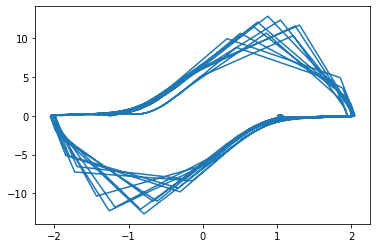

In [24]:
plt.plot(*np.array(values).T[:2], '-')

In [ ]:
(np.ptp(sol, axis=0)/np.ptp(xxxx, axis=0)) > 2.0

In [181]:
dir(getattr(dysts.flows, equation_name)())

['__annotations__',
 '__call__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_load_data',
 '_postprocessing',
 '_rhs',
 'a',
 'bifurcation_parameter',
 'bound_trajectory',
 'citation',
 'correlation_dimension',
 'data_path',
 'delay',
 'description',
 'dt',
 'embedding_dimension',
 'get_param_names',
 'hamiltonian',
 'ic',
 'initial_conditions',
 'kaplan_yorke_dimension',
 'lyapunov_spectrum_estimated',
 'make_trajectory',
 'maximum_lyapunov_estimated',
 'mu',
 'multiscale_entropy',
 'name',
 'nonautonomous',
 'parameters',
 'params',
 'period',
 'pesin_entropy',
 'random_state',
 'rhs',
 'unbounded_indices',
 'w']

[2]

In [65]:
%matplotlib inline
for equation_name in list(dataset.keys())[:19]:
    plt.figure()
    #plt.plot(np.array(dataset[equation_name]["values"]))
    plt.plot(np.array(dataset[equation_name]["values"])[:, 0],np.array(dataset[equation_name]["values"])[:, 1])
    plt.title(equation_name + " " + str(getattr(dysts.flows, equation_name)().correlation_dimension))

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 432x288 with 0 Axes>

KeyError: 'values'

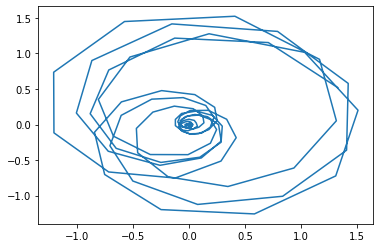

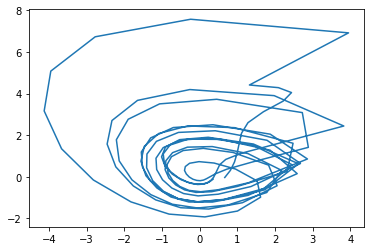

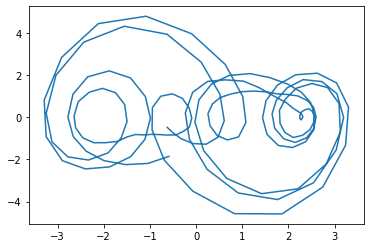

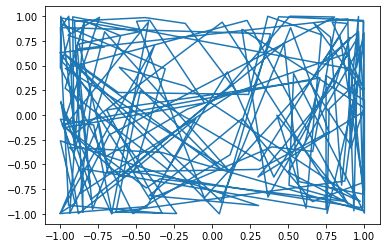

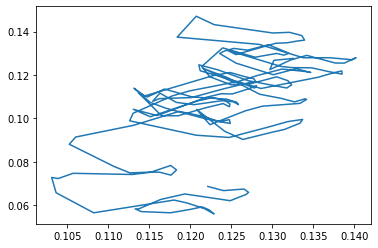

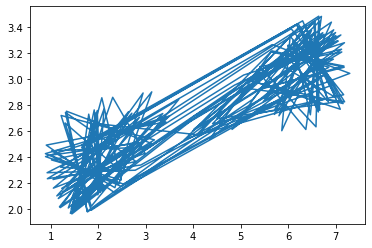

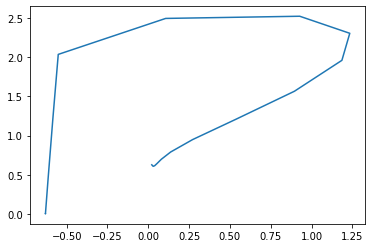

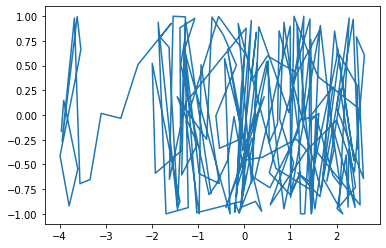

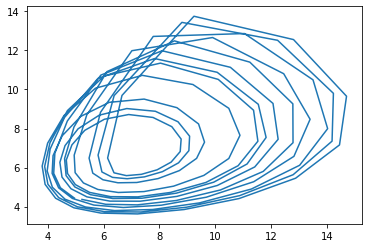

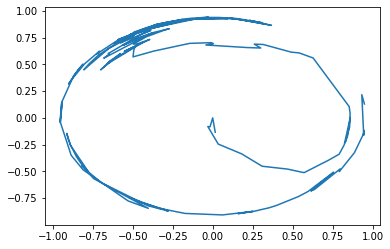

<Figure size 432x288 with 0 Axes>

In [34]:
%matplotlib inline
for equation_name in list(dataset.keys())[:19]:
    plt.figure()
    #plt.plot(np.array(dataset[equation_name]["values"]))
    plt.plot(np.array(dataset[equation_name]["values"])[:, 0],np.array(dataset[equation_name]["values"])[:, 1])

In [22]:
%matplotlib inline

plt.plot(np.array(dataset['SprottR']["values"])[:, 0],np.array(dataset['SprottR']["values"])[:, 1])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed